# Target Detection for FMCW Radar
***

In [1]:
# Imports
import numpy as np
from numpy.fft import fft, fftshift, ifft
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy
from scipy import signal, stats
from scipy.special import erf

# Formatting
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
# style.use('seaborn-dark')
# style.use('dark_background')

***
## Radar parameters, constants, filenames, etc.

In [2]:
sample_rate = 10e6
buffer_size = 2**14
rx_lo_freq = 2e9
tx_lo_freq = 2e9
adc_size = 2**12

c = 3e8

nc_file = 'radar_data.nc'

***
## Collect data from netCDF file

In [3]:
ds = nc.Dataset(nc_file)

i_data = ds.variables['i']
q_data = ds.variables['q']
units = i_data.units

# Take data from 1 time sample and create complex variable
iq_all = i_data[:] + 1j * q_data[:]
iq = iq_all[0,]
z_all = np.abs(iq_all)
z = np.abs(iq)

"""
    Plotting
"""
"""
# Plot time series
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

plt.plot(z / adc_size)
"""

# Compute DFT and plot
X_k = fft(iq) / (2 * buffer_size)
X_k = fftshift(X_k)
X_k_dBFS = 10 * np.log10(X_k / adc_size)
freq = np.linspace(-sample_rate / 2, sample_rate / 2, buffer_size)

"""
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Frequency [Hz]")
plt.ylabel("dBFS")

plt.plot(freq, X_k_dBFS)
"""

'\nfig = plt.figure()\nfig.set_figheight(8)\nfig.set_figwidth(16)\nplt.xlabel("Frequency [Hz]")\nplt.ylabel("dBFS")\n\nplt.plot(freq, X_k_dBFS)\n'

***
## Windowing
### Comparison of commonly used windows
|Type|Peak sidelobe amplitude [dB]|Approx. main lobe width [rad]|Peak approx. error, <br> $20log_{10}(\delta)$ [dB]|Equiv. kaiser window, <br> $\beta$|Equiv. kaiser window, <br> width [rad]| 
|-|-|-|-|-|-|
|Rectangular|-13|$\frac{4\pi}{M+1}$|-21|0|$\frac{1.81\pi}{M}$|
|Bartlett|-25|$\frac{8\pi}{M}$|-25|1.33|$\frac{2.37\pi}{M}$|
|Hanning|-31|$\frac{8\pi}{M}$|-44|3.86|$\frac{5.01\pi}{M}$|
|Hamming|-41|$\frac{8\pi}{M}$|-53|4.86|$\frac{6.27\pi}{M}$|
|Blackman|-57|$\frac{12\pi}{M}$|-74|7.04|$\frac{9.19\pi}{M}$|

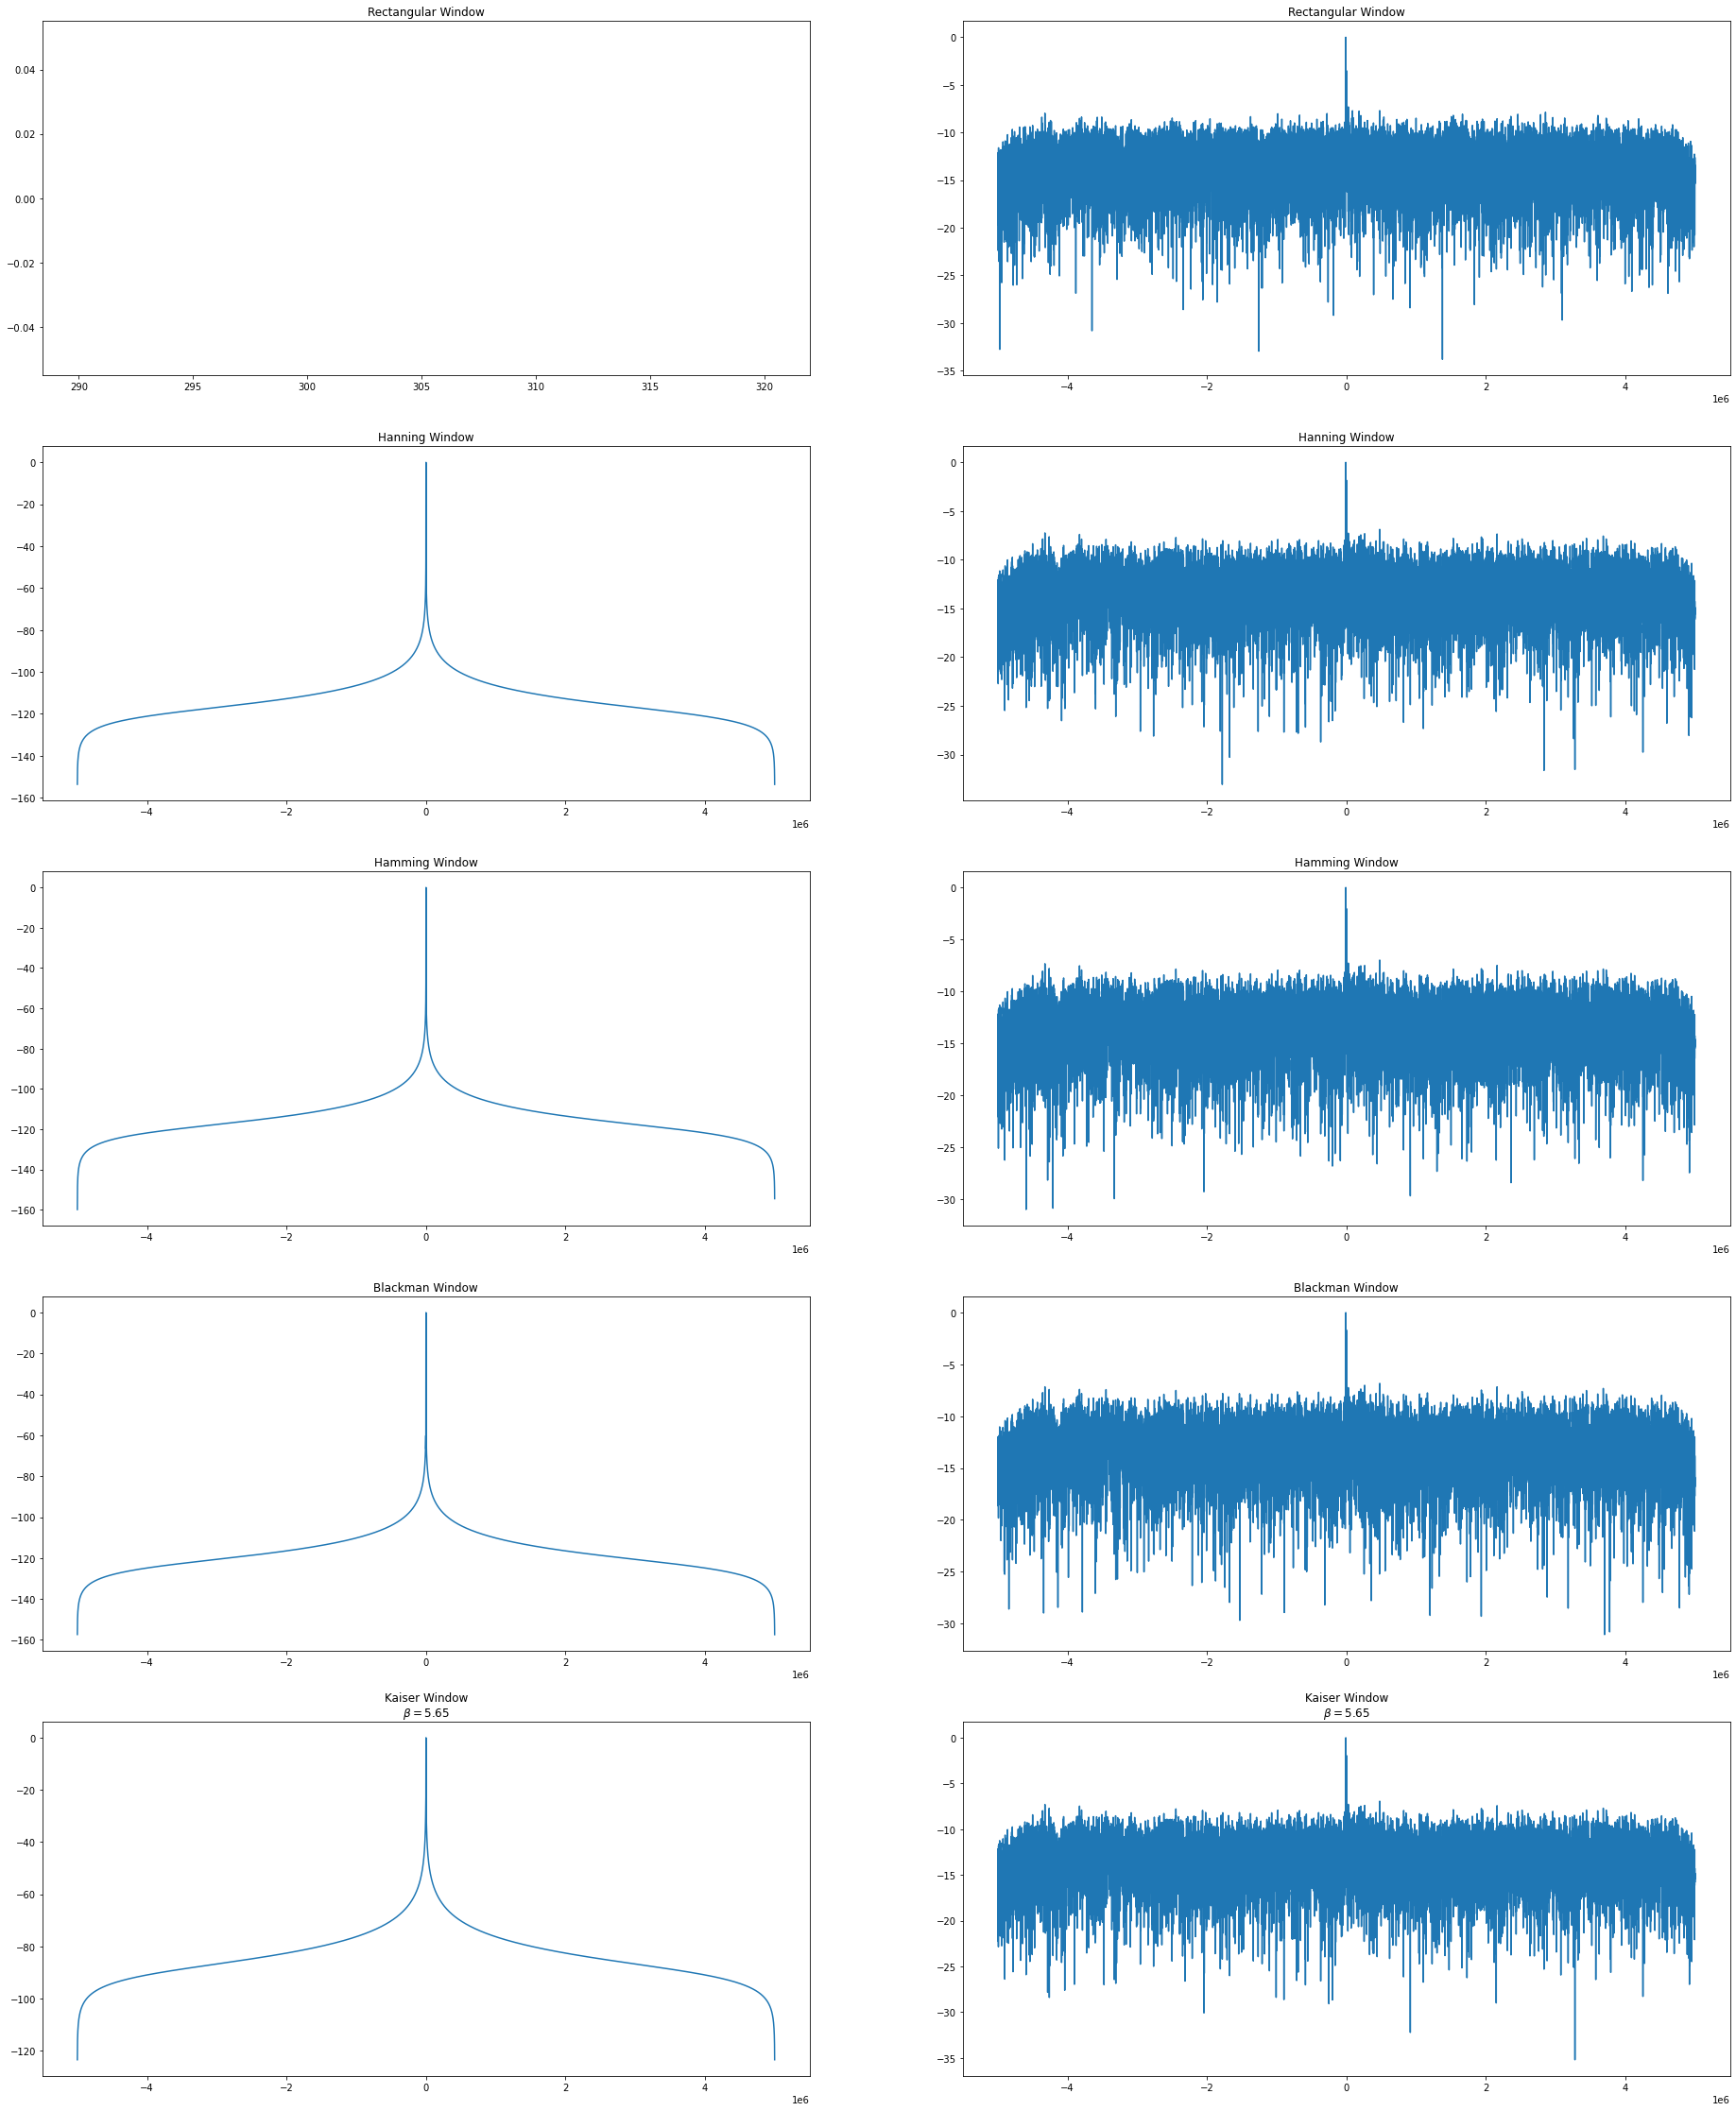

In [6]:
"""
    Create windows
"""
M = z.size
beta = 5.65

# Windows
w_n_rectangular = np.ones(M)
w_n_hanning = signal.windows.hann(M)
w_n_hamming = signal.windows.hamming(M)
w_n_blackman = signal.windows.blackman(M)
w_n_kaiser = signal.windows.kaiser(M, beta)

# Frequency response of windows
W_k_rectangular = fftshift(fft(w_n_rectangular))
W_k_hanning = fftshift(fft(w_n_hanning))
W_k_hamming = fftshift(fft(w_n_hamming))
W_k_blackman = fftshift(fft(w_n_blackman))
W_k_kaiser = fftshift(fft(w_n_kaiser))

y_n_hanning = iq * w_n_hanning
Y_k_hanning = np.abs(fft(y_n_hanning) / (2 * buffer_size))
Y_k_hanning = fftshift(Y_k_hanning)

y_n_hamming = iq * w_n_hamming
Y_k_hamming = np.abs(fft(y_n_hamming) / (2 * buffer_size))
Y_k_hamming = fftshift(Y_k_hamming)

y_n_blackman = iq * w_n_blackman
Y_k_blackman = np.abs(fft(y_n_blackman) / (2 * buffer_size))
Y_k_blackman = fftshift(Y_k_blackman)

y_n_kaiser = iq * w_n_kaiser
Y_k_kaiser = np.abs(fft(y_n_kaiser) / (2 * buffer_size))
Y_k_kaiser = fftshift(Y_k_kaiser)

"""
    Plotting
"""
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(32)

# Normal
axes[0][0].set_title("Rectangular Window")
axes[0][0].plot(freq, 10 * np.log10(W_k_rectangular / np.max(W_k_rectangular)))
axes[0][1].set_title("Rectangular Window")
axes[0][1].plot(freq, 10 * np.log10(X_k / np.max(X_k)))

# Hanning
axes[1][0].set_title("Hanning Window")
axes[1][0].plot(freq, 10 * np.log10(W_k_hanning / np.max(W_k_hanning)))
axes[1][1].set_title("Hanning Window")
axes[1][1].plot(freq, 10 * np.log10(Y_k_hanning / np.max(Y_k_hanning)))

# Hamming
axes[2][0].set_title("Hamming Window")
axes[2][0].plot(freq, 10 * np.log10(W_k_hamming / np.max(W_k_hamming)))
axes[2][1].set_title("Hamming Window")
axes[2][1].plot(freq, 10 * np.log10(Y_k_hamming / np.max(Y_k_hamming)))

# Blackman
axes[3][0].set_title("Blackman Window")
axes[3][0].plot(freq, 10 * np.log10(W_k_blackman / np.max(W_k_blackman)))
axes[3][1].set_title("Blackman Window")
axes[3][1].plot(freq, 10 * np.log10(Y_k_blackman / np.max(Y_k_blackman)))

# Kaiser
axes[4][0].set_title("Kaiser Window\n$\\beta=%0.2f$" % beta)
axes[4][0].plot(freq, 10 * np.log10(W_k_kaiser / np.max(W_k_kaiser)))
axes[4][1].set_title("Kaiser Window\n$\\beta=%0.2f$" % beta)
axes[4][1].plot(freq, 10 * np.log10(Y_k_kaiser / np.max(Y_k_kaiser)))

(400.0, 600.0)

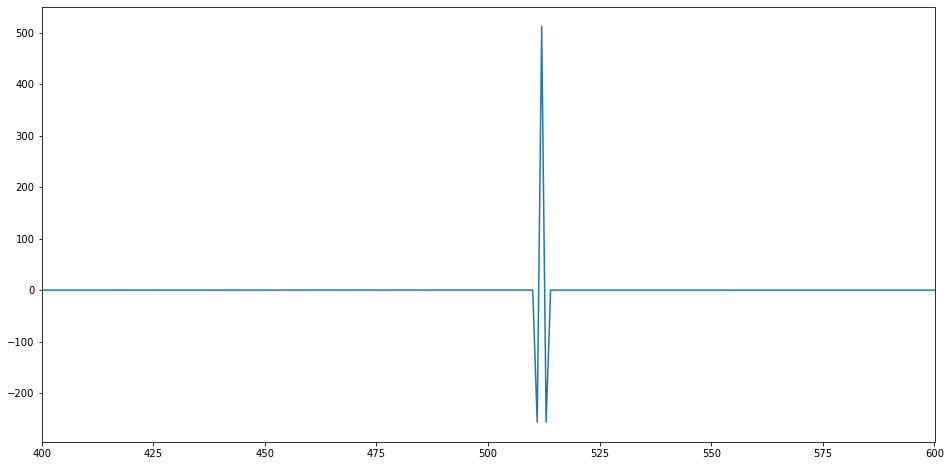

In [7]:
# Testing normal sized window

w_n = signal.windows.hann(1024)
W_k = fftshift(fft(w_n, 1024))

fig = plt.figure()
plt.plot(W_k)
fig.set_figwidth(16)
fig.set_figheight(8)
plt.xlim([400, 600])




***
## Noise calculation
### For coherent detectors, noise power can be estimated from the variance, $\sigma^2$,  (square of standard deviation)
$ \begin {align}
P_n &= \frac{\sigma^2}{2}
\end {align} $
<h2 style="color:red">INCOMPLETE</h2>

(3.0517578125000434e-05-0.00030517578125j)
Mean: 0.00
Standard deviation: 0.12
Variance: 0.02
Noise power: 	0.01 bits
		-114.57 dBFS


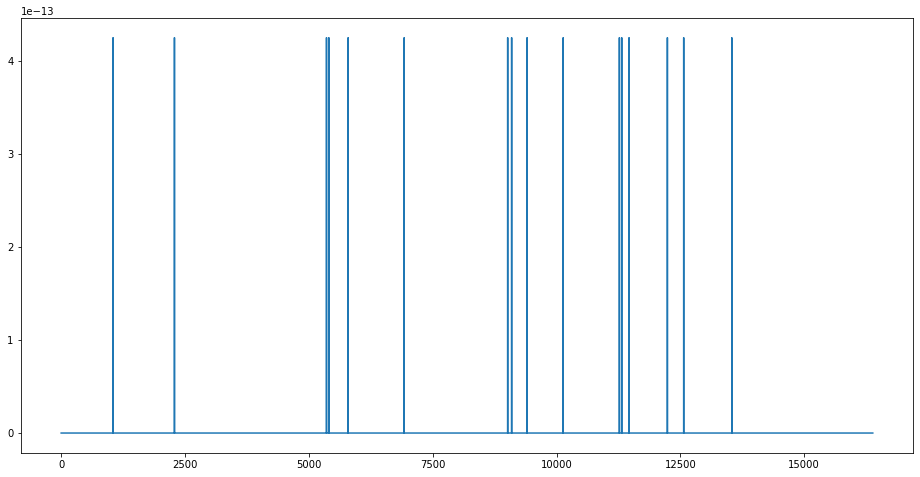

In [8]:
# Takes magnitude then caccalates standard deviation
# z = np.abs(iq)
mean = np.mean(X_k)
print(mean)
std = np.std(X_k)
variance = std**2
print("Mean: %0.2f\nStandard deviation: %0.2f\nVariance: %0.2f" 
    % (mean, std, variance))

noise_power = variance / 2
noise_dBFS = 20 * np.log10(noise_power / adc_size)

print("Noise power: \t%0.2f bits\n\t\t%0.2f dBFS" %(noise_power, noise_dBFS))

pdf = (z / variance) * np.exp(-1 * z**2 / (2 * variance))
fig = plt.figure()
plt.plot(pdf)
fig.set_figwidth(16)
fig.set_figheight(8)

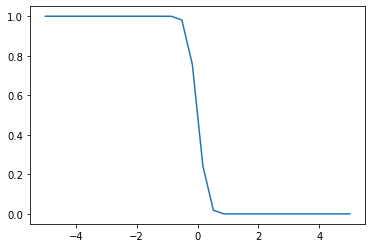

In [9]:
# Probability of false alarm
V = np.linspace(-5, 5, 30)
P_fa = 0.5 * (1 - scipy.special.erf(V / std**(0.5)))
plt.plot(V, P_fa)

In [10]:
np.sum(np.where(np.abs(iq) > adc_size))

0

***
## False alarm
### A false alarm occurs when noise jumps beyond the noise floor to a level similar to that of targets. There exists a voltage threshold, $V_T$, between a target and noise that is determined using SNR and determines the probability of false alarms, $P_{fa}$. The probability of false alarm and detection, $P_{fa}$ and $P_d$, respectively, are given by the following equations,
$ \begin {align}
P_{fa} &= \int_{V_T}^{\infty} \frac{1}{\sigma \sqrt{2\pi}}\text{exp} \left( - \frac{y^2}{2\sigma^2} \right) dy \\
&= \frac{1}{2} \left[ 1 - erf\left( \frac{V_T}{\sqrt{2}\sigma} \right) \right] \\
& \\
P_d &= \int_{V_T}^{\infty} \frac{1}{\sigma \sqrt{2\pi}}\text{exp} \left( - \frac{(y-A)^2}{2\sigma^2} \right) dy \\
&= \frac{1}{2} \left[ 1 - erf\left( \frac{V_T - A}{\sqrt{2}\sigma} \right) \right] \\
\end {align} $
### where $A$ is the signal amplitude, $\sigma$ is the standard deviation, and $erf(\cdot)$ is the error function. For a desired false alarm rate, $V_T$ can be calculated by, 
$ \begin {align}
V_T &= \sqrt{-2\sigma^2 ln(P_{fa})} \ . \\
\end {align} $

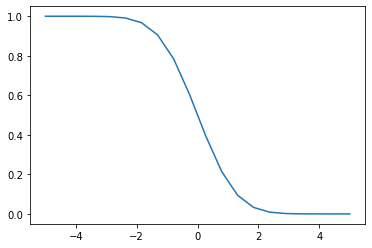

In [11]:
v_threshold = np.linspace(-5, 5, 20)
std_dev = 1

prob_fa = 0.5 * (1 - erf(v_threshold / (2**(0.5) * std_dev)))

plt.plot(v_threshold, prob_fa)

***
## CFAR - Constant False Alarm Rate
### Since an incoming signal is constantly changing, the threshold, $V_T$, must also constantly update to classify parts of the signal as targets with the same false alarm rate.
### **Common techniques:**
#### **Cell averaging** - The mean power is taken of all the cells surrounding the cell under test (CUT), by the following equation:
$ \begin {align}
Z &= \frac{1}{N}\sum_{n=1}^{N}X_n \\ 
N &- \text{number of range cells being averaged} \\
X_n &- \text{signal power of } n^{th} \text{cell} \\
Z &- \text{local noise power estimate}
\end {align} $
#### **Greatest** - This is the same as the cell averaging technique but it only uses the nearby cells on the side of the CUT that have the larger mean.
#### **Smallest** - Very similar to the greatest technique but it takes the nearby cells with the smaller of the two means. 
#### **Ordered statistic** - *NOT IMPLEMENTED*
#### **Cell averaging Statistic Hofele** - *NOT IMPLEMENTED*

#### To reduce interference from the CUT, nearby cells are omitted from the mean power and are called *guard cells*. 

#### To determine if a cell will be considered a target, the cell's value, $X$, must be greater than the average of the nearby cells multiplied by a bias factor, $C$. In other words, $X \ge CZ$ for a cell to be classified as a target.

In [4]:
def cfar(X_k, num_guard_cells, num_ref_cells, bias, cfar_method='average'):
    N = X_k.size
    cfar_values = np.zeros(X_k.shape)
    for center_index in range(num_guard_cells + num_ref_cells, N - (num_guard_cells + num_ref_cells)):
        min_index = center_index - (num_guard_cells + num_ref_cells)
        min_guard = center_index - num_guard_cells 
        max_index = center_index + (num_guard_cells + num_ref_cells) + 1
        max_guard = center_index + num_guard_cells + 1

        lower_nearby = data[min_index:min_guard]
        upper_nearby = data[max_guard:max_index]

        lower_mean = np.mean(lower_nearby)
        upper_mean = np.mean(upper_nearby)

        if (cfar_method == 'average'):
            mean = np.mean(np.concatenate((lower_nearby, upper_nearby)))
        elif (cfar_method == 'greatest'):
            mean = max(lower_mean, upper_mean)
        elif (cfar_method == 'smallest'):
            mean = min(lower_mean, upper_mean)
        else:
            mean = 0

        output = mean * bias
        cfar_values[center_index] = output

    targets_only = np.copy(X_k)
    targets_only[np.where(X_k < cfar_values)] = np.ma.masked

    return cfar_values, targets_only


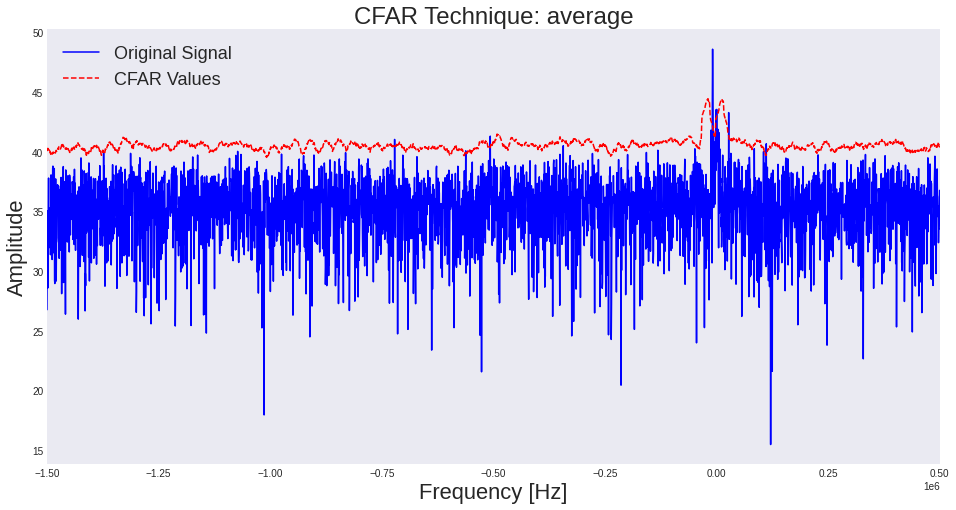

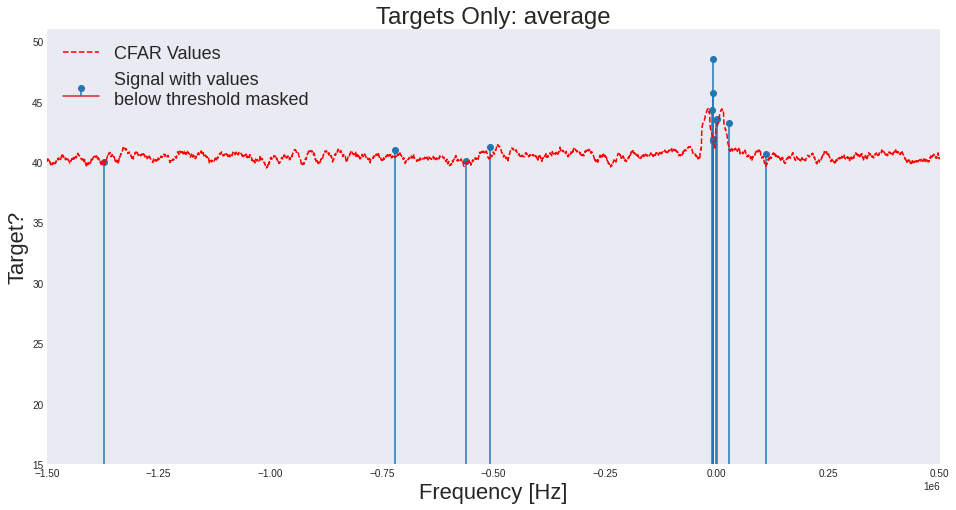

In [5]:
# Original signal
X_k_all = fftshift(fft(iq_all))
data = np.abs(X_k_all[0])
# data = np.abs(X_k)

"""
    Options:
        'average'
        'greatest'
        'smallest'
"""
cfar_method = 'average'
# cfar_method = 'greatest'
# cfar_method = 'smallest'

# Cell averaging parameters
num_guard_cells = 10
num_ref_cells = 30
bias = 3

time = 0
cfar_values, targets_only = cfar(data, num_guard_cells, num_ref_cells, bias, cfar_method)

"""
    Plotting
"""
# Plot CFAR values and original signal
fig, ax = plt.subplots()
ax.set_title("CFAR Technique: %s" % cfar_method, fontsize=24)
ax.set_xlabel("Frequency [Hz]", fontsize=22)
ax.set_ylabel("Amplitude", fontsize=22)
# fig.legend(['Original Signal', 'CFAR Values'], loc='upper right', fontsize=12)
fig.set_figheight(8)
fig.set_figwidth(16)
ax.set_xlim([-1.5e6, 0.5e6])

ax.plot(freq, 10 * np.log10(data), color='b', label="Original Signal")
# plt.axis('off')
# plt.title('FFT of Received Signal', fontsize=20)
ax.plot(freq, 10 * np.log10(cfar_values), color='r', linestyle='dashed', label='CFAR Values')
ax.legend(fontsize=18, loc='upper left')

# Plot targets only
fig, ax = plt.subplots()
ax.set_title("Targets Only: %s" % cfar_method, fontsize=24)
ax.set_xlabel("Frequency [Hz]", fontsize=22)
ax.set_ylabel("Target?", fontsize=22)
fig.set_figheight(8)
fig.set_figwidth(16)
ax.set_xlim([-1.5e6, 0.5e6])
ax.set_ylim([15, 51])

ax.stem(freq, 10 * np.log10(targets_only), label='Signal with values \nbelow threshold masked')
ax.plot(freq, 10 * np.log10(cfar_values), color='r', linestyle='dashed', label='CFAR Values')
ax.legend(fontsize=18, loc='upper left')

In [11]:
X_k_all = fftshift(fft(iq_all))

X_k_all = np.zeros(iq_all.shape)
X_k_all = np.array(list(map(lambda x : fftshift(fft(x)), iq_all)))
X_k_all.shape

(19, 16384)